# Tutorial - Rede de Reações Químicas

---
- Criador: João Guilherme dos Santos Caramês
- Data: 06/12/2023

---

Olá cientista !
---

Esse código é um tutorial de como fazer uma rede de reações químicas com python. Para isso, precisamos entender primeiro o que é uma rede de reações químicas computacionalmente para saber o que precisamos fazer, certo?

Nesse sentido, uma rede de reações é um grafo, ou seja, um conjunto de dados (vértice dos grafos) que possuem relações entre si (arestas dos grafos). No nosso caso, os vértices são divididos em dois conjuntos, compostos e reações, os quais são ligados por arestas direcionais (ou simplesmente setas). Assim, um composto que é reagentes de uma reação tem uma seta que sai deles em direção à reação e os produtos dela uma seta que sai da reação em direção a eles.

Dessa maneira, precisamos representar os compostos e as reações computacionalmente.

## Compostos

Computacionalmente, podemos representar compostos químicos por meio de identificadores, os quais são, em sua maioria, são strings (ou simplesmente palavras) que representam de alguma maneira sua composição e estrutura ou apenas elementos de um "índice remissivo" para encontrar suas informações em um banco de dados. Nesse contexto, diversos identificadores foram criados e para esse tutorial eu escolhi o SMILES.

1. Simplified Molecular-Input Line-Entry System (SMILES): esse identificador descreve as moléculas a partir dos elementos que fazem parte de sua composição e da maneira que estão arranjados. Assim, alguns compostos podem ser descritos por mais de um SMILES, mas um SMILES somente remete a um compostos. Para usarmos eles como identificadores, precisamos garantir que cada composto será representado por um único SMILES, o canônico.
    
    Exemplo de SMILES (Etanol): $CH_3CH_2OH \xrightarrow{} CCO$. Em português, da esquerda para a direita, um carbono alifático (C) ligado a outro carbono alifático (C) ligado a um oxigênio alifático (O). Sim, os hidrogênios são omitidos por simplicidade.
    
Para esse tutorial, trabalheremos com a biblioteca RDKIT, a qual consegue gerar moléculas a partir de identificadores, então instale ela.

In [ ]:
pip install rdkit

Com isso, vamos ver como o RDKIT representa o Etanol a partir do seu SMILES e do seu módulo Chem.

- SMILES_Etanol: string que define o SMILES do Etanol.
- MolFromSmiles: função do módulo Chem do RDKIT que gera moléculas a partir do SMILES.
- MolToImage: permite visualizar as moléculas.

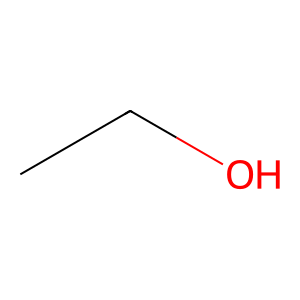

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw

SMILES_Etanol = "CCO"

Etanol = Chem.MolFromSmiles(SMILES_Etanol)
imagem_Etanol = Draw.MolToImage(Etanol)

imagem_Etanol

Com isso, podemos colocar todas as moléculas na rede de reações de maneira única e usá-las computacionalmente com sua representação do RDKIT. Todavia, a quantidade de compostos numa rede de reações pode ser muito grande, então não vamos gerar molécula por molécula e sim fazer isso iterativamente a partir dos SMILES, os quais são conhecidos e podem ser listados.

Nesse sentido, a abordagem a seguir foi uma opção tomada apenas para fins didáticos, já que espera-se que ao desenvolver uma rede a partir de N compostos, já iremos conhecer os SMILES de todos eles. Dessa forma, vamos extrair os SMILES de compostos que fazem parte de duas reações, o etanol, a água, o eteno, o catecol e o 4-etil catecol, a partir do PubChem.

O [PubChem](https://pubchem.ncbi.nlm.nih.gov/) é uma base de dados químicos de acesso livre da National Center for Biotechnology Information (NCBI) dos Estados Unidos. No PubChem podemos encontrar vários identificadores das moléculas, inclusive o SMILES, e podemos usar da biblioteca em python dele para extrair diretamente essas informações no python. Então vamos instalar ela também.

In [ ]:
pip install pubchempy

A iteração a seguir foi feita apenas para gerar a lista de SMILES. Novamente, se você já tiver ela ou mesmo prefira fazer de outra maneira, pode ignorar esse uso do pubchempy.

Agora vamos buscar no pubchempy os SMILES a partir do nome em inglês dos compostos de interesse. Para isso:

1. Organizamos os compostos em uma lista.
2. Definimos uma maneira de armazenar os smiles, um dicionário, no caso.
3. Fazemos uma iteração. Leia cada linha de código para mais detalhes em português nos comentários.
    - get_compounds: busca qual é o código do pubchem (CID) para aquele composto
    - canonical_smiles: busca qual o SMILES daquele código.
4. Visualizamos o resultado da busca.

In [2]:
import pubchempy as pcp

# Lista de compostos
nomes_compostos = ['water', 'ethanol', 'ethene','catechol', '4-Ethylcatechol']

# Dicionário para armazenar os SMILES
smiles_compostos = {}

# Loop para gerar os SMILES
for nome in nomes_compostos: # Para cada nome na lista de nomes
    composto = pcp.get_compounds(nome, 'name')[0] # Buscamos o código do composto no PubChem com o nome
    smiles = composto.canonical_smiles # Buscamos o SMILES a partir do código do composto
    mol = Chem.MolFromSmiles(smiles) # Fazemos a molécula pelo RDKIT
    smiles_canonico = Chem.MolToSmiles(mol) # Retiramos o SMILES da molécula do RDKIT
    smiles_compostos[nome] = [smiles_canonico, mol] # Armazenamos no dicionário, onde a chave é o nome do composto e o valor é uma lista com smiles e mol

# Vendo os resultados da busca
for nome, lista in smiles_compostos.items():
    print(f'{nome}: {lista[0]}')

water: O
ethanol: CCO
ethene: C=C
catechol: Oc1ccccc1O
4-Ethylcatechol: CCc1ccc(O)c(O)c1


## Reações

Com os compostos em mão, vamos definir as reações. Para isso, nós usamos os SMARTS:

2. SMILES arbitrary target specification (SMARTS): esse código permite representar reações específicas ou gerais por meio dos SMILES.
    Exemplo de SMARTS (Desidratação do Etanol):
    - Reação: $CH_3CH_2OH \xrightarrow{} C_2H_4 + H_2O$
    - SMARTS: CCO>>C=C . O

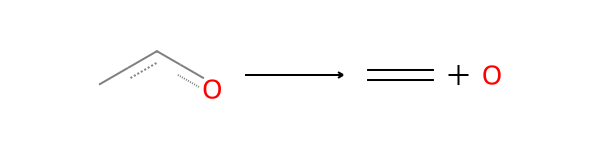

In [4]:
from rdkit.Chem import AllChem

etanol_desidratacao = AllChem.ReactionFromSmarts('CCO>>C=C.O')
etanol_desidratacao

Os SMARTS se tornam realmente interessantes quando generalizamos as reações, ou seja, desenhamos a reação de modo que qualquer compostos que tenha um padrão determinado possa reagir. Dessa forma, podemos escrever a desidratação de forma generalizada assim:

Desidratação: [C!H0:1][C:2][OH1:3]>>[C:1]=[C:2].[O:3]

Dessa maneira, podemos fazer a reação para o etanol e colher os produtos gerados nela.

Assim, vamos primeiro usar o módulo AllChem do RDKIT que permite realizar reaçõea a partir do SMARTS.

In [5]:
# SMARTS para a desidratação
smarts_desidratacao = '[C!H0:1][C:2][OH1:3]>>[C:1]=[C:2].[O:3]'

# Convertendo o SMARTS para um objeto de reação do RDKIT
reacao_desidratacao = AllChem.ReactionFromSmarts(smarts_desidratacao)

# Criando o reagente
Etanol = Chem.MolFromSmiles('CCO')

# Executando a reação
desidratacao_etanol_produtos = reacao_desidratacao.RunReactants((Etanol,))

# Exibindo os produtos da reação
for produto in desidratacao_etanol_produtos:
    for mol in produto:
        print(Chem.MolToSmiles(mol))

C=C
O


Tendo a primeira reação definida, falta a segunda, que é a reação entre catecol e etanol. Vamos definir então o SMARTS dela para fazer a reação de alquilação de moléculas aromáticas com o etanol, liberando compostos aromáticos com um etil e água.

[*:0][c:1].[C:2][C:3]=[O:4]>>[*:0][c:1][C:2][C:3].[O:4]

In [6]:
# SMARTS para a alquilação com etanol
smarts_alquilacao = '[*:0][c:1].[C:2][C:3]=[O:4]>>[*:0][c:1][C:2][C:3].[O:4]'

# Convertendo o SMARTS para um objeto de reação do RDKIT
reacao_alquilacao = AllChem.ReactionFromSmarts(smarts_alquilacao)

# Criando os reagentes
Catecol = Chem.MolFromSmiles('Oc1ccccc1O')
Etanol = Chem.MolFromSmiles('[C:2][C:3]=[O:4]')

# Executando a reação
alquilacao_catecol_produtos = reacao_alquilacao.RunReactants([Catecol,Etanol])

# Exibindo os produtos da reação
for i in range(len(alquilacao_catecol_produtos)):
    produto = alquilacao_catecol_produtos[i]
    for mol in produto:
        smiles_produto = Chem.MolToSmiles(mol)
        print(i, smiles_produto)

0 CCc1(O)ccccc1O
0 O
1 CCc1cccc(O)c-1O
1 O
2 CCc1(O)ccccc-1O
2 O
3 CCc1(O)c(O)cccc-1
3 O
4 CCc1ccc(O)c(O)c-1
4 O
5 CCc1c(O)c(O)ccc-1
5 O
6 CCc1cc(O)c(O)cc-1
6 O
7 CCc1cc(O)c(O)cc-1
7 O
8 CCc1c(O)c(O)ccc-1
8 O
9 CCc1ccc(O)c(O)c-1
9 O
10 CCc1(O)c(O)cccc-1
10 O
11 CCc1cccc(O)c-1O
11 O
12 CCc1(O)ccccc-1O
12 O
13 CCc1(O)ccccc1O
13 O


Como podemos ver, diversos produtos foram gerados, isso quer dizer que o RDKIT nos retornou todas as formas possíveis de posicionar a etila no anel aromático. Para evitar isso, poderíamos colocar mais restrições dentro do SMARTS ou filtrar os produtos gerados com base nos nossos conhecimentos sobre a termodinâmica das reações e então guardar aqueles com maior probabilidade de ocorrer. No nosso caso, vou apenas escolher o composto desejado, o 4-etil catecol ('CCc1ccc(O)c(O)c-1').

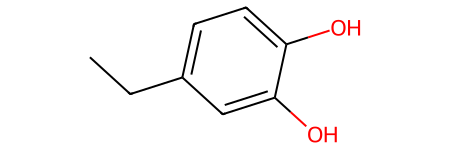

In [7]:
quatro_etil_catecol = alquilacao_catecol_produtos[4][0] # Seleciona aos produtos da reação 4 e depois o produto 0
agua = alquilacao_catecol_produtos[4][1] # Seleciona aos produtos da reação 4 e depois o produto 1
quatro_etil_catecol

## Construção da Rede de Reações

Com tudo isso, para gerar redes maiores, seria necessário juntar toda a lógica vista até agora com a que vem agora numa única iteração, mas isso não seria nem um pouco didático.

Agora, para construir nossa rede de reações precisamos da ajuda de uma biblioteca que nos permite fazer os grafos direcionais (com setas) bipartidos (separando os nós de compostos e reações) e do matplotlib para ver. Vamos usar o networkx para essa missão, então instale eles.

In [ ]:
pip install networkx

In [ ]:
pip install matplotlib

In [8]:
import networkx
from networkx.algorithms import bipartite

Depois, vamos fazer a uma lista com os compostos usando os smiles a partir das reações que corremos e outra com as reações e definir manualmente as ligações. Lembrando novamente que para redes maiores esses passos fariam parte da iteração de reações, a fim de adiocinar essas relações a cada reação gerada.

In [9]:
# SMILES dos Reagentes

Catecol_Smiles = 'Oc1ccccc1O'
Etanol_Smiles = 'CCO'

# SMILES dos Produtos das reações a partir das moléculas geradas nas reações

eteno = desidratacao_etanol_produtos[0][0]
Eteno_Smiles = Chem.MolToSmiles(eteno)

quatro_etil_catecol = alquilacao_catecol_produtos[4][0]
Quatro_Etil_Catecol_Smiles = Chem.MolToSmiles(quatro_etil_catecol)

agua = alquilacao_catecol_produtos[4][1]
Agua_Smiles = Chem.MolToSmiles(agua)


#Lista de compostos
lista_compostos = [Catecol_Smiles, Etanol_Smiles, Eteno_Smiles, Agua_Smiles, Quatro_Etil_Catecol_Smiles]

A lista de reações pode ser definida da maneira que achar melhor. Aqui, será com o nome da reação, mas numa rede maior, pode ser com base no tipo de reação, por exemplo, Desidratação_0, Desidratação_1, Desidratação_2 ...

In [10]:
#Lista de reações
lista_reacoes = ['Desidratação do etanol', 'Alquilacão do catecol']

Agora vamos dividir os conjuntos para a rede.

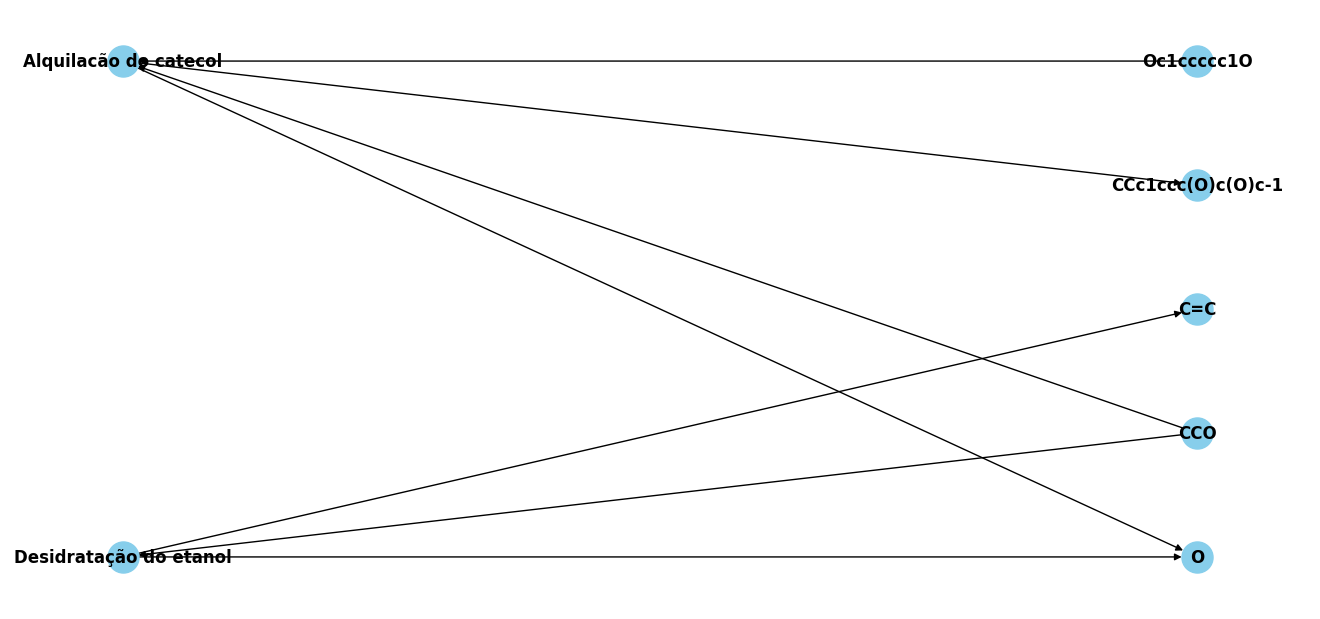

In [13]:
import matplotlib.pyplot as plt

# Criando um grafo direcionado bipartido
fig = plt.figure(figsize=(13,6))
Rede = networkx.DiGraph()

# Adicionando os conjuntos de nós a rede
Rede.add_nodes_from(lista_reacoes, bipartite=0)  # Marca os nós de reação com o lado 0 por padrão
Rede.add_nodes_from(lista_compostos, bipartite=1)  # Marca os nós de compostos com o lado 1 por padrão


# Criando arestas para a desidratação do etanol
arestas_desidratacao_etanol = [(Etanol_Smiles, 'Desidratação do etanol'), ('Desidratação do etanol', Eteno_Smiles), ('Desidratação do etanol', Agua_Smiles)]
Rede.add_edges_from(arestas_desidratacao_etanol)

# Criando arestas para a alquilação do catecol
arestas_alquilacao_etanol = [(Catecol_Smiles, 'Alquilacão do catecol'), (Etanol_Smiles, 'Alquilacão do catecol'), ('Alquilacão do catecol', Quatro_Etil_Catecol_Smiles), ('Alquilacão do catecol', Agua_Smiles)]
Rede.add_edges_from(arestas_alquilacao_etanol)

# Visualização do grafo
pos = networkx.drawing.layout.bipartite_layout(Rede,lista_reacoes)
networkx.draw(Rede, pos, with_labels=True, node_color='skyblue', node_size=500, font_weight='bold')
plt.show()

Com isso, finalizamos o tutorial de rede de reações usando python por meio do RDKIT. Sempre aceito sugestões de melhoria, então entre em contato se quiser trocar ideias sobre o assunto pelo github. Abraço e siga bem cientista.